In [15]:
#!/usr/bin/env python
import numpy as np
import pylab as pl
pl.ion()

# Create a class triangular object with 3 points (xy)
class TriangularObstacle(object):
  def __init__(self, x0, y0, x1, y1, x2, y2):
    self.x0 = x0
    self.y0 = y0
    self.x1 = x1
    self.y1 = y1
    self.x2 = x2
    self.y2 = y2

    #Return a new array of given shape and type, filled with zeros.
    self.A = np.zeros((3,2))
    self.C = np.zeros(3)

    a = x1 - x0
    b = y1 - y0
    c = x2 - x0
    d = y2 - y0
    if -b*c + a*d > 0:
      self.A[0, :] = -b, a
    else:
      self.A[0, :] = b, -a
    
    # C[0] contain the dot product of A and point 0
    self.C[0] = np.dot(self.A[0, :], np.array([x0,y0]))

    a = x2 - x1
    b = y2 - y1
    c = x0 - x1
    d = y0 - y1
    if -b*c + a*d > 0:
      self.A[1, :] = -b, a
    else:
      self.A[1, :] = b, -a
    self.C[1] = np.dot(self.A[1, :], np.array([x1,y1]))

    a = x0 - x2
    b = y0 - y2
    c = x1 - x2
    d = y1 - y2
    if -b*c + a*d > 0:
      self.A[2, :] = -b, a
    else:
      self.A[2, :] = b, -a
    self.C[2] = np.dot(self.A[2, :], np.array([x2,y2]))


  def contains(self, x, y):
    r = np.dot(self.A, np.array([x,y])) - self.C
    return all([i>0 for i in r])

# Plot the triangle.
# pylab.plot: plot y versus x as lines and/or markers. The coordinates of the points or line nodes are given by x, y.


  def plot(self):
    pl.plot([self.x0,self.x1], [self.y0,self.y1], "r" , linewidth = 2)
    pl.plot([self.x1,self.x2], [self.y1,self.y2], "r" , linewidth = 2)
    pl.plot([self.x2,self.x0], [self.y2,self.y0], "r" , linewidth = 2)        

#Create the environment with specified size and number of object (triangle) in the environment
class Environment(object):
  def __init__(self, size_x, size_y, n_obs):
    self.size_x = size_x
    self.size_y = size_y
    self.obs = []
    for i in range(n_obs):
      x0 = np.random.rand()*size_x
      y0 = np.random.rand()*size_y
      x1 = np.random.rand()*size_x
      y1 = np.random.rand()*size_y
      x2 = np.random.rand()*size_x
      y2 = np.random.rand()*size_y
      self.obs.append(TriangularObstacle(x0, y0, x1, y1, x2, y2))

  def check_collision(self, x, y): # x&y as input is the location of the point. Check whether the point is inside triangle
    for ob in self.obs: #self.obs are all the triangles
      if ob.contains(x, y):
        return True
    return False

  def random_query(self):
    max_attempts = 100 #number of max attempts to create the start & finish point that is random
    found_start = False # Initialize the boolean whether start & finish is founded or not
    found_goal = False
    for i in range(max_attempts): #Create random start point, if not inside the obs, found start is true. Continue
      x_start = np.random.rand()*self.size_x
      y_start = np.random.rand()*self.size_y
      if not self.check_collision(x_start, y_start):
        found_start = True
        break
    for i in range(max_attempts): #Likewise, create random finish point
      x_goal = np.random.rand()*self.size_x
      y_goal = np.random.rand()*self.size_y
      if not self.check_collision(x_goal, y_goal):
        found_goal = True
        break
    if found_start and found_goal: #If start & finish points are valid, return the coordinates
      return x_start, y_start, x_goal, y_goal
    else:
      return None

  def plot(self): #Function to plot the environment and obstacles
    pl.plot([0, self.size_x, self.size_x, 0, 0], [0, 0, self.size_y, self.size_y, 0], "k", linewidth = 2)
    for ob in self.obs:
      ob.plot()

  def plot_query(self, x_start, y_start, x_goal, y_goal): # Plot the start & finish point according to random_query
    pl.plot([x_start], [y_start], "bs", markersize = 8)
    pl.plot([x_goal], [y_goal], "y*", markersize = 12)

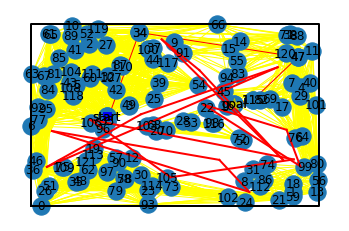

In [121]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import math
import networkx as nx

#The given environment
import sys
sys.path.append('osr_examples/scripts/')

# Import the environment_2d.py 
import environment_2d

#turn interactive mode on
pl.ion()

# Seed the generator.
size_x = 10
size_y = 6
n_obs = 5
space = 150 #Number of random space points

env = environment_2d.Environment(size_x,size_y,n_obs) #Initialize the environment size 10x6 and the 5 obstacles

#Clear the current figure.
pl.clf()

#Plot the environment (triangle obstacle)
env.plot()


q = env.random_query() #Initialize the start & finish points randomly as q
if q is not None:
  x_start, y_start, x_goal, y_goal = q #transfer to each variable
  env.plot_query(x_start, y_start, x_goal, y_goal) #plot the starting and finish point
    
#Step 1 of PRM, create the free space
#Create random points in space
X = []
Y = []
for i in range(space):
      X.append(np.random.rand()*size_x)
      Y.append(np.random.rand()*size_y)
    
#Check for collision
Xfree = []
Yfree = []

for i in range(space):
    if not env.check_collision(X[i],Y[i]):
        Xfree.append(X[i])
        Yfree.append(Y[i])

free = {}     
for i in range(len(Xfree)):
    free[i] = [Xfree[i], Yfree[i]]
    
#Plot the free space even if the path is not found        
plt.scatter(Xfree,Yfree)

#function to return distance between 2 points
def dist(x0,y0, x1,y1):
  return math.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))

#Step 2: Make a function to check for collision along lines 
#To do so, need to put the triangles points into polygon data type

#function to get the triangle points and put it into an array
def get_triangle_points(arr):
  temp_Triangle = []

  temp_Triangle.append(getattr(arr, 'x0'))
  temp_Triangle.append(getattr(arr, 'y0'))
  temp_Triangle.append(getattr(arr, 'x1'))
  temp_Triangle.append(getattr(arr, 'y1'))
  temp_Triangle.append(getattr(arr, 'x2'))
  temp_Triangle.append(getattr(arr, 'y2'))

  return temp_Triangle

# saves Polygon type data of the obstacle triangles
triangle = []

for i in env.obs:
  temp = get_triangle_points(i)
  triangle.append(Polygon( [(temp[0],temp[1]),(temp[2],temp[3]),(temp[4],temp[5])] ))

max_dist = 6    
# Step 3: Create the graph and connect the starting & goal point to the graph

# Create the edges via networkx
G = nx.Graph()

for i in free:
  G.add_node(i, pos=(free[i][0], free[i][1])) #Put in all the free space points into graph as nodes

for i in range(len(free)):
  for j in range(i+1, len(free)): #Check each points
    if dist(free[i][0], free[i][1], free[j][0], free[j][1]) <= max_dist: 
      temp = LineString([ (free[i][0], free[i][1]), (free[j][0], free[j][1]) ]) #put in the 4 points as temporary line
      intersect = False
      for obs in triangle:
        if temp.intersects(obs): #If the temporary line intersect with the obstacle, break the operation
          intersect = True
          break
      if intersect == False: #If the temporary line does not intersect, put it in graph as edge
        G.add_edge(i, j)

#Add the start and goal into the graph
G.add_node('start', pos=(x_start, y_start)) 
G.add_node('goal', pos=(x_goal, y_goal))

#Check whether a direct path from start to goal is possible
start_to_goal = LineString([(x_start,y_start),(x_goal,y_goal)])
intersect = False
for obs in triangle:
    if start_to_goal.intersects(obs):
        intersect = True
        break
if intersect == False:
    G.add_edge('start','goal')

for i in range(len(free)):
  ## Start Point
  if dist(free[i][0], free[i][1], x_start, y_start) <= max_dist:
    temp = LineString([ (free[i][0], free[i][1]), (x_start, y_start) ]) #put in the 4 points as temporary line
    intersect = False
    for obs in triangle:
      if temp.intersects(obs): #If the temporary line intersect with the obstacle, break the operation
        intersect = True
        break
    if intersect == False: #If the temporary line does not intersect, put it in graph as edge
      G.add_edge(i, 'start', weight=dist(free[i][0], free[i][1], x_start, y_start))
  ## Goal Point
  if dist(free[i][0], free[i][1], x_goal, y_goal) <= max_dist:
    temp = LineString([ (free[i][0], free[i][1]), (x_goal, y_goal) ]) #put in the 4 points as temporary line
    intersect = False
    for obs in triangle:
      if temp.intersects(obs): #If the temporary line intersect with the obstacle, break the operation
        intersect = True
        break
    if intersect == False: #If the temporary line does not intersect, put it in graph as edge
      G.add_edge(i, 'goal', weight=dist(free[i][0], free[i][1], x_goal, y_goal))

#Step 4: Find the shortest distance by using A* algorithm
a_star_route_index = nx.astar_path(G, 'start', 'goal')

#Create a_star Path
# Add nodes
a_star_route = nx.Graph()
for i in a_star_route_index:
  if i == 'start':
    a_star_route.add_node(i, pos=(x_start, y_start))
  elif i == 'goal':
    a_star_route.add_node(i, pos=(x_goal, y_goal))
  else:
    a_star_route.add_node(i, pos=(free[i][0], free[i][1]))

# Add Edge
# find pairs
a_star_route_edge = list(zip(a_star_route_index, a_star_route_index[1:]))

for i in a_star_route_edge:
  a_star_route.add_edge(i[0], i[1])


nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, edge_color='yellow')
nx.draw(a_star_route, nx.get_node_attributes(a_star_route, 'pos'), with_labels=True, edge_color='red')


In [122]:
a_star_route_index

['start', 33, 34, 47, 115, 'goal']

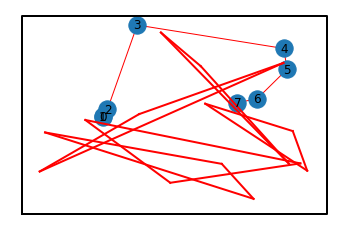

In [123]:
#Functions used for post processing
#Return (x,y) point between 2 points (x0,y0)&(x1,y1)
def point_between(x0,y0,x1,y1):
    return ((x1-x0)/2+x0,(y1-y0)/2+y0)

#A function that return an array that contain n pair of points that segment a line equally
def segment(arr,x0,y0,x1,y1,n):
    if n!=0:
        temp_x, temp_y = point_between(x0,y0,x1,y1)
        arr.append(point_between(x0,y0,x1,y1))
        segment(arr,temp_x,temp_y,x1,y1,n-1)
        segment(arr,x0,y0,temp_x,temp_y,n-1)
        
def line_segment(x0,y0,x1,y1,n):
    arr = []
    segment(arr,x0,y0,x1,y1,n)
    return arr

def segment_path(x0,y0,x1,y1,x2,y2):
    arr = [(x0,y0),(x1,y1),(x2,y2)]
    line1 = line_segment(x0,y0,x1,y1,3)
    line2 = line_segment(x1,y1,x2,y2,3)
    return [line1,line2]

#A function that takes in 3 point and return an array of linestring that does not collide with obstacle
def create_line(x0,y0,x1,y1,x2,y2):
    array_line = []
    segment_point = segment_path(x0,y0,x1,y1,x2,y2)
    line1 = segment_point[0]
    line2 = segment_point[1]
    for i in range(len(line1)):
        for j in range(i,len(line2)):
            temp =  LineString([line1[i],line2[j]])
            intersect = False
            for obs in triangle:
                if temp.intersects(obs):
                  intersect = True
                  break
            if intersect == False:
                array_line.append(temp)
    return array_line

#A function that takes in an array of linestring and return a linestring with shortest distance
def choose_line(array_line,start,end): 
    total = 100
    for i in range(len(array_line)):
        p1 = list(array_line[i].coords)[0]
        p2 = list(array_line[i].coords)[1]
        start_mid_dist = dist(start[0],start[1],p1[0],p1[1])
        mid_end_dist = dist(end[0],end[1],p2[0],p2[1])
        mid = array_line[i].length
        temp_total = start_mid_dist + mid + mid_end_dist
        if total > temp_total:
            total = temp_total
            line = array_line[i]
    return line

#Receive path coordinate and return sets of turns(three points) in dictionary format
def divide_path(path_coor):
    path_turns = {}
    j = 0
    for i in range(0,len(path_coor)-2,2):
        path_turns[j] = [path_coor[i],path_coor[i+1],path_coor[i+2]]
        j += 1
    return path_turns

#Function that takes in turns and output shortened turns 
def add_shortcut(shortcut,turn):
    shortcut_p = list(shortcut.coords)
    p1_node = [shortcut_p[0][0],shortcut_p[0][1]]
    p2_node = [shortcut_p[1][0],shortcut_p[1][1]]
    turn.pop(1)
    if p1_node != turn[0]:
        turn.insert(1,p1_node)
        if p2_node != turn[2]:
            turn.insert(2,p2_node)
    elif p2_node != turn[1]:
            turn.insert(1,p2_node)
    return turn

#Incorporate shortcut function and return dictionary of shortened turns
def shortcut_path(path_turns):
    short_turns = {}
    for i in range(len(path_turns)):
        x0 = path_turns[i][0][0]
        y0 = path_turns[i][0][1]
        x1 = path_turns[i][1][0]
        y1 = path_turns[i][1][1]
        x2 = path_turns[i][2][0]
        y2 = path_turns[i][2][1]
        shortcut_line = choose_line(create_line(x0,y0,x1,y1,x2,y2),[x0,y0],[x2,y2]) #Create the shortcut line
        short_turns[i] = add_shortcut(shortcut_line,path_turns[i])
    return short_turns

def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list

def main(a_star_route_index):
    path_coor = []
    for i in range(len(a_star_route_index)): #Put the path coordinate into an array
        if a_star_route_index[i] == 'start':
            path_coor.append([x_start,y_start])
        elif a_star_route_index[i] == 'goal':
            path_coor.append([x_goal,y_goal])
        else:
            path_coor.append(free[a_star_route_index[i]])
            
    new_path_turn = shortcut_path(divide_path(path_coor)) #Input the path coordinate and return dictionary with shortened turns
    new_path = [] #Initialize new path array to put the coordinate from the dictionary back
    for i in range(len(new_path_turn)):
        for j in range(len(new_path_turn[i])):
            new_path.append(new_path_turn[i][j])
    if new_path[-1] != path_coor[-1]:
        new_path.append(path_coor[-1])
    new_path = unique(new_path) #Delete duplicate
    
    #Graph it by using linestring
    env.plot()
    Gshort = nx.Graph()
    Gshort_index = []
    for i in range(len(new_path)):
        Gshort.add_node(i, pos = (new_path[i][0],new_path[i][1]))
        Gshort_index.append(i)
    Gshort_edge = list(zip(Gshort_index,Gshort_index[1:]))
    for i in Gshort_edge:
        Gshort.add_edge(i[0],i[1])
    nx.draw(Gshort,nx.get_node_attributes(Gshort,'pos'), with_labels=True,edge_color="red")

if len(a_star_route_index) > 2:
    main(a_star_route_index)
elif len(a_star_route_index) == 2:
    print("There's a straight route from Start to Goal. Route already optimized")